Case study 2:  particle-particle bridge
===

TODO: Add link to paper in each header

#### The first few cells in this notebook define the imports, physical and numerical parameters used in the case study. The parameters can be modified by the user to produce new results.

In [63]:
# Imports and physical parameters
import numpy as np
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from ipywidgets import *
from matplotlib.widgets import Slider

# ddg imports

from ddgclib._complex import Complex
from ddgclib import *
from ddgclib._complex import *
from ddgclib._curvatures import * #plot_surface#, curvature
from ddgclib._capillary_rise_flow import * #plot_surface#, curvature
from ddgclib._hyperboloid import *
from ddgclib._catenoid import *
from ddgclib._ellipsoid import *
from ddgclib._eos import *
from ddgclib._misc import *
from ddgclib._plotting import *
from ddgclib._case2 import *

# Parameters for a water droplet in air at standard laboratory conditions
gamma = 0.0728  # N/m, surface tension of water at 20 deg C
rho = 1000  # kg/m3, density
g = 9.81  # m/s2

# Numerical parameters #Stated this is what to plaay
r = 1
theta_p = 20 * np.pi/180.0  # rad, three phase contact angle
refinement=1  # NOTE: 2 is the minimum refinement needed for the complex to be manifold

/home/endres/iwt-projects/ddg/ddgclib/ddgclib/_complex.py:2732: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  self.ax_surface = self.fig_surface.gca(projection='3d')


AttributeError: <class 'ddgclib._vertex.VertexCube'> object has no attribute 'f'

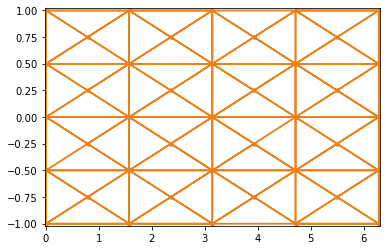

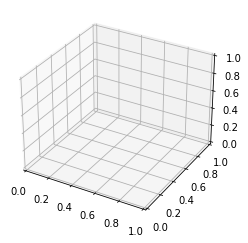

In [66]:
# TODO: Explain plane projection
# Explain how to project to other surfaces
# Exlain here projectio nto catenoid
domain = [(0.0, 2 * np.pi),  # u
          (-1, 1)  # v
              ]
HC_plane = Complex(2, domain)
HC_plane.triangulate()
refinement = 2
for i in range(refinement):
    HC_plane.refine_all()
    
HC_plane.plot_complex()

In the manuscript we used the catenoid as our analytical comparison, a descretized catenoid from the mapping function can be produced using `catenoid_N`:

In [64]:
a, b, c = 1, 0.0, 1  # Geometric parameters of the catenoid
abc = (a, b, c)
HC, bV, K_f, H_f, neck_verts, neck_sols = catenoid_N(r, theta_p, gamma, abc, N=N,
    refinement=refinement,
    cdist=1e-5, equilibrium=True)

Explain analytical solution lists

As always we can vasualize the resulting complex using `.plot_complex` method of the `Complex` class:

/home/endres/iwt-projects/ddg/ddgclib/ddgclib/_complex.py:2764: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  self.ax_complex = Axes3D(self.fig_complex)
/home/endres/iwt-projects/ddg/ddgclib/ddgclib/_complex.py:2831: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig_complex.show()


(<Figure size 432x288 with 1 Axes>, <Axes3D:>, None, None)

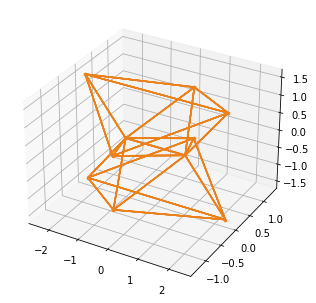

In [65]:
HC.plot_complex()

As in the first case study we can again make use of the `int_curvatures` function to compute all the curvatures at every vertex used in this case study.

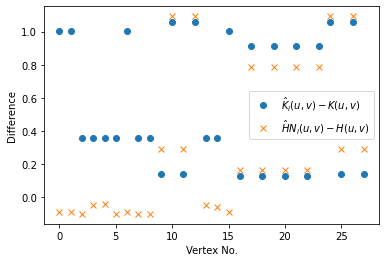

In [40]:
# Compute all curvatures:
(HNda_v_cache, K_H_cache, C_ijk_v_cache, HN_i,  HNdA_ij_dot_hnda_i,
     K_H_2, HNdA_i_Cij) = int_curvatures(HC, bV, r, theta_p, printout=0)

# Process the results:
c_outd2 = []  #TODO not needed?
HN_i_2 = []
HNdA_i_list = []
C_ij_i_list = []
for v in HC.V:
    if v in bV:
        continue
    nullp = np.zeros(3)
    nullp[2] = v.x_a[2]
    N_f0 = v.x_a - nullp  # First approximation of normal vectors
    N_f0 = normalized(N_f0)[0]
    F, nn = vectorise_vnn(v)
    c_outd2 = b_curvatures_hn_ij_c_ij(F, nn, n_i=N_f0)
    HN_i_2.append(c_outd2['HN_i'])
    HNdA_i_list.append(c_outd2['HNdA_i'])
    C_ij_i_list.append(c_outd2['C_ij'])

# Plot results
K_f = np.array(K_f)
H_f = np.array(H_f)
plt.figure()
yr = K_H_2 - K_f
xr = list(range(len(yr)))
plt.plot(xr, yr, 'o', label='$\hat{K}_i(u, v) - K(u, v)$')
yr = HNdA_ij_dot_hnda_i - H_f
plt.plot(xr, yr, 'x', label='$\hat{H}N_i(u, v)  - H(u, v)$')

# Subtract the analytical solution from the numerical output:
yr = HN_i_2 -  H_f

l_hnda_i_cij = []
for hnda_i_cij in HNdA_i_Cij:
    l_hnda_i_cij.append(np.sum(hnda_i_cij))

yr = l_hnda_i_cij - H_f
plt.ylabel('Difference')
plt.xlabel('Vertex No.')
plt.legend()

In [41]:
HC.V.size()

36

While this provides us with the _point-wise_ errors at each vertex, we are also interested in the _total integrated_ error over the entire liquid-bridge. Imbalances is what results in the physical surface tension forces. For the Catenoid we expect values close to zero (exactly zero at the analytical solution): 

In [42]:
# Sum all the curvature tensor errors in the postive 'upwards' direction
sum_HNdA_i = 0.0
for hndA_i, c_ij in zip(HNdA_i_list, C_ij_i_list):
    hndA_i_c_ij = hndA_i / np.sum(c_ij)
    sum_HNdA_i += np.dot(hndA_i_c_ij, [0, 0, 1])

# Print out results:
print(f'Number of vertices in the complex: {HC.V.size()}')  # 
print(f'Number of boundary vertices in the complex: {len(bV)}')  # n
print(f'Integrated curvature sum_HNdA_i in (0, 0, 1) direction = {sum_HNdA_i}')

# Sum all the curvature tensor errors in the negative 'upwards' direction
for hndA_i, c_ij in zip(HNdA_i_list, C_ij_i_list):
    hndA_i_c_ij = hndA_i / np.sum(c_ij)
    sum_HNdA_i += np.dot(hndA_i_c_ij, [0, 0, -1])

print(f'Integrated curvature sum_HNdA_i in (0, 0, -1) direction = {sum_HNdA_i}')

# Compute the geometric error
max_int_e = 0.0
ern = 0.0
for v in bV:
    for v2 in v.nn:
        if v2 in bV:  # Explain
            a = v.x_a
            b = v2.x_a
            break
    ern = 0.5 * numpy.linalg.norm(a - b) ** 2
    max_int_e = ern
    break

#erange.append(max_int_e / r)
print(f'geo erange = {ern }')


Number of vertices in the complex: 36
Number of boundary vertices in the complex: 8
Integrated curvature sum_HNdA_i in (0, 0, 1) direction = 4.4967285103836296e-17
Integrated curvature sum_HNdA_i in (0, 0, -1) direction = -8.131516293641283e-20
geo erange = 5.533830997888883


# Comparing errors for different refinements 

By changing the `refinement` parameter with `N=4` in the first cell, we can recompute the curvatures for different refinements of the bridge. The data in the following cell can be collected by repeating the calculations above (note that floating point accuracy of the numpy build (LAPLACK vs. ATLAS) on your systems could produce slightly different results):NOTE: EXPLAIN ALSO WHAT THE USER SHOULD EXPECT TO SEE!

In [10]:
Nlist = [8, 16, 32, 64]  # Number of BOUNDARY Vertices
N_total = [36, 136, 528, 2080]  # Total number of vertices 

lp_error = [0, 0, 0, 0]
lp_error = np.array(lp_error) +  np.random.rand(4) * 4 *np.random.rand(4) * 1e-12

lp_error = [4.5902409477605044e-17,
            2.4001525593397854e-16,
            -3.5415463964239e-16,
            -1.652188585596348e-16
            ]
lp_error_2 = [-4.0657581468206416e-20,
              -6.2341624917916505e-19,
               2.710505431213761e-19,
               5.624298769768554e-18
              ]
# geo_erro should be proportion to area based
#geo_error = [a/(2**2+1), a/(2**3+1), a/(2**4+1), a/(2**5+1)]  # area based
geo_error = [5.533830997888883,
             1.6208215733413345,
             0.4212378025628348,
             0.1063310109203463

             ]

Finally we plot the data:

y=-1.904895x+(2.481425)


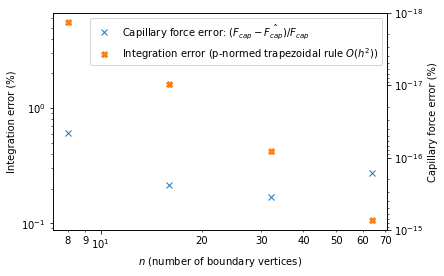

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax2 = ax.twinx()
ln1 = ax2.loglog(Nlist, np.abs(lp_error), 'x', color='tab:blue',
             label='Capillary force error: $(F_{cap} - \hat{F_{cap}}) / F_{cap} $')

ax2.set_ylabel(r'Capillary force error (%)')
ax.set_xlabel(r'$n$ (number of boundary vertices)')

ln2 = ax.loglog(Nlist, geo_error, 'X', color='tab:orange',
          label='Integration error (p-normed trapezoidal rule $O(h^2)$)')

ax.set_ylabel(r'Integration error (%)')

ax2.set_ylim([1e-15, 1e-18])
lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)
plt.tick_params(axis='y', which='minor')

x, y = Nlist, geo_error
x, y = np.float32(x), np.float32(y)
z = numpy.polyfit(x, y, 1)
z = np.polyfit(np.log10(x), np.log10(y), 1)

p = numpy.poly1d(z)
p = np.poly1d(z)
# the line equation:
print("y=%.6fx+(%.6f)" % (z[0], z[1]))

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

plt.tick_params(axis='y', which='minor')
if 1:
    from matplotlib import pyplot as plt, ticker as mticker

    ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())
    ax2.xaxis.set_minor_formatter(mticker.ScalarFormatter())